Author: Afonso Eduardo

**Goal:** Given an Amazon product reviews dataset, predict whether a review will be rated helpful by other users.

## Exploratory Data Analysis

### Data Prep

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline

In [2]:
# Load the dataset and display contents
data = pd.read_csv("Clothing_Shoes_and_Jewelry_5.csv")
len_data = len(data)
print(f"Length of dataset: {len_data}")
data.head()

Length of dataset: 278677


,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0000031887,"[0, 0]",5,This is a great tutu and at a really great pri...,"02 12, 2011",A1KLRMWW2FWPL4,"Amazon Customer ""cameramom""",Great tutu- not cheaply made,1297468800
1,0000031887,"[0, 0]",5,I bought this for my 4 yr old daughter for dan...,"01 19, 2013",A2G5TCU2WDFZ65,Amazon Customer,Very Cute!!,1358553600
2,0000031887,"[0, 0]",5,What can I say... my daughters have it in oran...,"01 4, 2013",A1RLQXYNCMWRWN,Carola,I have buy more than one,1357257600
3,0000031887,"[0, 0]",5,"We bought several tutus at once, and they are ...","04 27, 2014",A8U3FAMSJVHS5,Caromcg,"Adorable, Sturdy",1398556800
4,0000031887,"[0, 0]",5,Thank you Halo Heaven great product for Little...,"03 15, 2014",A3GEOILWLK86XM,CJ,Grammy's Angels Love it,1394841600


In [3]:
# Convert the 'reviewTime' column to datetime format
data['reviewTime'] = pd.to_datetime(data['reviewTime'], format='%m %d, %Y')
# Sort the dataset by 'reviewTime'
data = data.sort_values(by='reviewTime')
# Drop duplicate and nan reviews to avoid spam messages
data = data.dropna(subset=['reviewText'])
data_unique = data.drop_duplicates('reviewText').reset_index(drop=True)
len_data_unique = len(data_unique)
print(f"The reviews are from {data_unique.loc[0, 'reviewTime'].date()}"
      f" to {data_unique.loc[data_unique.index[-1], 'reviewTime'].date()}.")
print(f"Removed {len_data - len_data_unique} duplicates (and nan)."
      f" Length of new dataset: {len_data_unique}.")

The reviews are from 2003-03-29 to 2014-07-23.
Removed 152 duplicates (and nan). Length of new dataset: 278525.


In [4]:
# Separate the 'helpful' column into two integer columns 'helpfulVotes'
# and 'totalVotes'
data_unique[['helpfulVotes', 'totalVotes']] = data_unique['helpful'].str.strip('[]').str.split(', ', expand=True).astype(int)
# Calculate unhelpful votes
data_unique['unhelpfulVotes'] = data_unique['totalVotes'] - data_unique['helpfulVotes']
# Define 'helpfulness' as the difference between helpful votes and unhelpful votes
data_unique['helpfulness'] = data_unique['helpfulVotes'] - data_unique['unhelpfulVotes']
# Define 'isHelpful' as positive helpfulness
data_unique['isHelpful'] = (data_unique['helpfulness'] > 0).astype(int)

count    278525.000000
mean          0.945678
std           6.234927
min        -241.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1133.000000
Name: helpfulness, dtype: float64


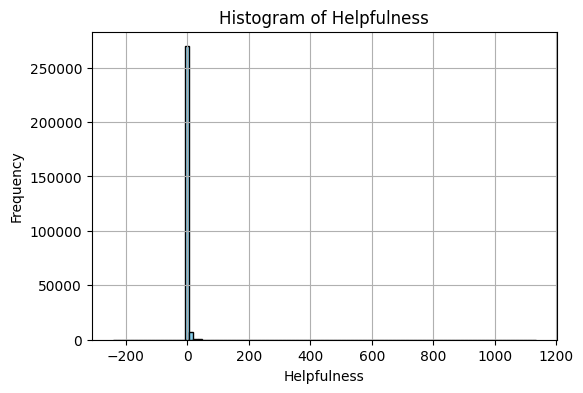

In [5]:
# Display summary stats of 'helpfulness'
print(data_unique.helpfulness.describe())
# Plot the respective histogram
plt.figure(figsize=(6, 4))
plt.hist(data_unique['helpfulness'], bins=100, color='skyblue', edgecolor='black')
plt.title('Histogram of Helpfulness')
plt.xlabel('Helpfulness')
plt.ylabel('Frequency')
plt.grid(True)

The majority of reviews are not deemed helpful, receiving a score of 0.
Among the reviews that are helpful, most receive a relatively low number of votes.

### Correlations with Helpfulness

Text(0.5, 1.0, 'Correlation Matrix')

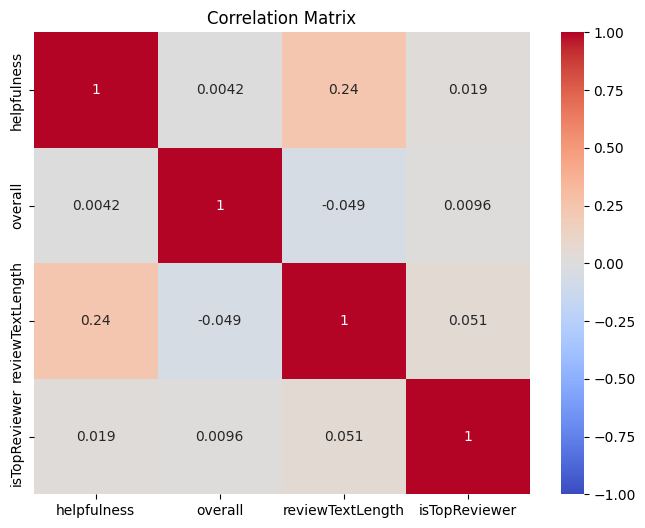

In [6]:
# Compute review text length
data_unique['reviewTextLength'] = data_unique['reviewText'].apply(len)
# Determine if a reviewer is in the top 1% of most reviews written
reviewer_counts = data_unique['reviewerID'].value_counts()
threshold = reviewer_counts.quantile(0.99)
top_1_percent_reviewers = reviewer_counts[reviewer_counts >= threshold].index
data_unique['isTopReviewer'] = data_unique.reviewerID.isin(top_1_percent_reviewers).astype(int)
# Compute and plot correlations
correlation_matrix = data_unique[['helpfulness', 'overall', 'reviewTextLength', 'isTopReviewer']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=True)
plt.title('Correlation Matrix')

There is a slight positive correlation between helpfulness and overall product rating, indicating that it is possible to find helpful reviews even for low-rated products. Additionally, helpfulness shows a positive correlation with both the length of the review text and the status of being a top reviewer, with the correlation being stronger for review text length.

In [7]:
# Summary stats of text length
data_unique['reviewTextLength'].describe()

count    278525.000000
mean        315.403238
std         330.711299
min           2.000000
25%         139.000000
50%         213.000000
75%         366.000000
max       22646.000000
Name: reviewTextLength, dtype: float64

The median review contains 213 characters. However, lengthy reviews, reaching up to 22646 characters, pull the mean up to 315 characters.

### Most Helpful Reviewers

In [8]:
# Review with maximum helpfulness by Cypress Green (not a TopReviewer)
maxHelpfulnessReview = data_unique[data_unique["helpfulness"] == data_unique["helpfulness"].max()]
maxHelpfulnessReview

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,helpfulVotes,totalVotes,unhelpfulVotes,helpfulness,isHelpful,reviewTextLength,isTopReviewer
11252,B003G4IM4S,"[1200, 1267]",5,I spotted this after viewing some fun items li...,2011-08-12,A1DDZAE5NREK1O,"Cypress Green ""She Who Has a Book in Hand Eve...",An Actual Review...With Actual Description!,1313107200,1200,1267,67,1133,1,2333,0


In [9]:
pd.options.display.max_colwidth = 5000
maxHelpfulnessReview['reviewText']

11252    I spotted this after viewing some fun items likeUranium OreandCanned Unicorn Meat. After hearing just how much fun people have with a horse mask, I knew I had to have one! Especially after I searched the web and found a picture of a guy wearing this with hooded jacket...that was especially freaky!I got this one (alas, only available at outside sites right now) because it seems to be the most realistic looking, plus has that all-important disturbing feel.1.  Heavy duty materials.2.  Has a slit up the back for easy donning and removal. Slit is barely visible as there's "mane hair" on both sides of it.  Image of this added.3.  How do you see? Through the horse's mouth and the nose holes. Nothing mars the look of those creepy eyes! It is easy to see out while wearing.4.  Has a "real" bushy hair mane. I had to look closely at the other parts because I could have sworn it had a fine dusting of hair all over. No, it's just extremely realistic looking!I already used it on the dogs.  T

The review is a detailed, with over 2300 characters, and humorous account of the reviewer's experience with a horse mask. The reviewer initially discovered the mask while browsing for quirky items and was compelled to buy it after seeing amusing pictures online. They highlight several features of the mask. The reviewer also shares various entertaining incidents involving the mask, such as scaring their pets, husband and coworkers. Overall, the reviewer finds the mask worth every dollar, citing its high-quality construction and the fun it brings.

In [10]:
# Top 3 reviewers with most helpful reviews
# Filter the dataset to include only helpful reviews
helpful_reviews = data_unique[data_unique['isHelpful'] == 1]
# Count the number of helpful reviews per reviewerID
helpful_review_counts = helpful_reviews['reviewerID'].value_counts()
# Get the top 3 reviewers with the most helpful reviews
top_3_reviewers = helpful_review_counts.head(3)
for reviewerID, numHelpful in top_3_reviewers.items():
  reviewerName = data_unique[data_unique['reviewerID'] == reviewerID]['reviewerName'].iloc[0]
  print(f"{reviewerName} with ID {reviewerID} wrote {numHelpful} helpful reviews.")
  print(helpful_reviews[helpful_reviews['reviewerID'] == reviewerID][['overall', 'helpfulness', 'reviewTextLength']].describe(), end="\n\n")

Matthew G. Sherwin with ID A2R6RA8FRBS608 wrote 45 helpful reviews.
         overall  helpfulness  reviewTextLength
count  45.000000    45.000000         45.000000
mean    4.844444    20.244444       1339.933333
std     0.424026    22.643638        348.255940
min     3.000000     1.000000        442.000000
25%     5.000000     3.000000       1181.000000
50%     5.000000    15.000000       1360.000000
75%     5.000000    25.000000       1470.000000
max     5.000000   111.000000       2067.000000

Kelli "Kelli K" with ID A2KBV88FL48CFS wrote 45 helpful reviews.
         overall  helpfulness  reviewTextLength
count  45.000000    45.000000         45.000000
mean    4.711111     6.377778        569.888889
std     0.626034     6.379259        277.311625
min     3.000000     1.000000        123.000000
25%     5.000000     2.000000        387.000000
50%     5.000000     4.000000        542.000000
75%     5.000000     9.000000        635.000000
max     5.000000    30.000000       1341.000000

C

Matthew G. Sherwin wrote the longest reviews on average (approximately 1300 characters, compared to 600 characters for Kelly and Candy Cane). His reviews also received the most helpfulness on average (20 votes, compared to approximately 6 for Kelly and Candy Cane). The majority of reviews were positive with a product rating of 5 stars.

### Analysis over Time

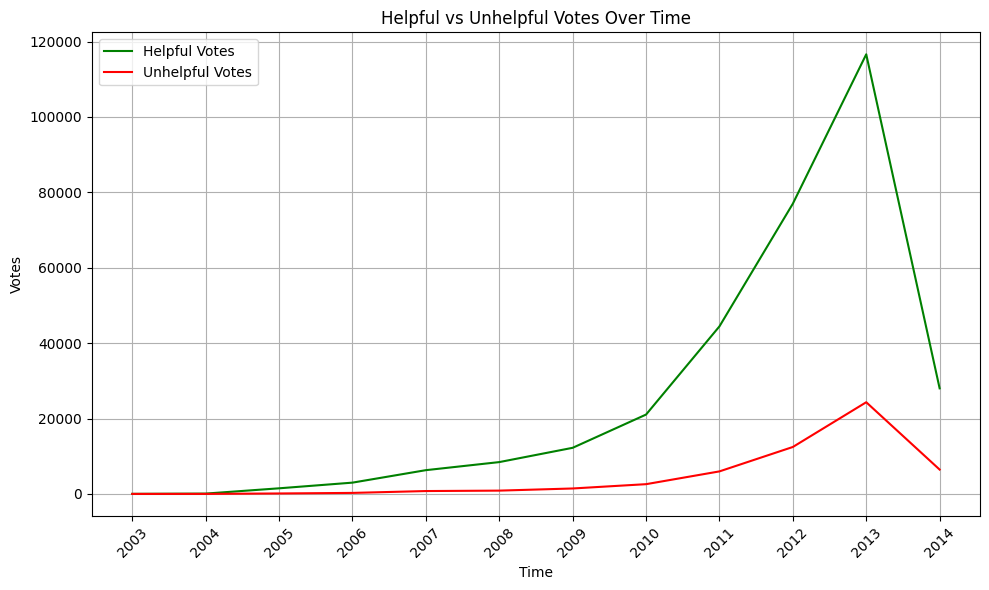

In [11]:
# Plot Helpful vs Unhelpful Votes Over Time
data_unique['year'] = data_unique['reviewTime'].dt.year
grouped = data_unique.groupby('year').agg({'helpfulVotes': 'sum',
                                           'unhelpfulVotes': 'sum'}).reset_index()
plt.figure(figsize=(10, 6))
plt.plot(grouped['year'], grouped['helpfulVotes'],
         label='Helpful Votes', color='green')
plt.plot(grouped['year'], grouped['unhelpfulVotes'],
         label='Unhelpful Votes', color='red')
plt.title('Helpful vs Unhelpful Votes Over Time')
plt.xlabel('Time')
plt.ylabel('Votes')
plt.legend()
plt.grid(True)
plt.xticks(grouped['year'], grouped['year'], rotation=45)
plt.tight_layout()

Between 2003 and 2013, the average proportion of helpful votes increased. However, it sharply declined in 2014.

isHelpful           0           1
reviewTime                       
2003         0.000000  100.000000
2004         0.000000  100.000000
2005        11.111111   88.888889
2006         9.565217   90.434783
2007        25.720621   74.279379
2008        31.682028   68.317972
2009        35.400361   64.599639
2010        41.493056   58.506944
2011        46.561706   53.438294
2012        61.982357   38.017643
2013        75.718266   24.281734
2014        86.213865   13.786135


<Figure size 1000x600 with 0 Axes>

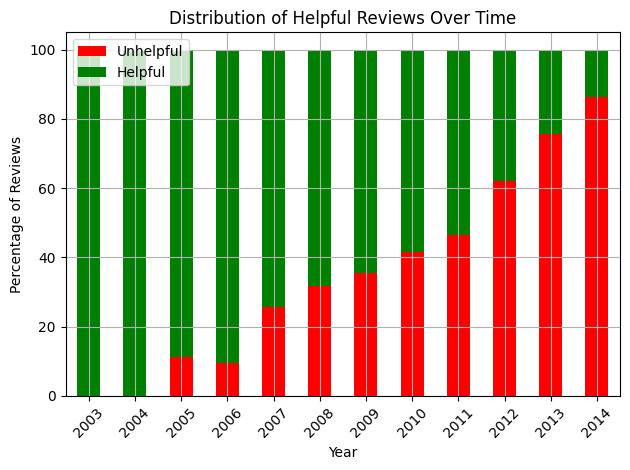

In [12]:
# Plot Distribution of Helpful Reviews Over Time
grouped = data_unique.groupby([pd.Grouper(key='reviewTime', freq='YE'),
                               'isHelpful']).size().unstack(fill_value=0)
grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100
grouped_percentage.index = grouped_percentage.index.year
plt.figure(figsize=(10, 6))
grouped_percentage.plot(kind='bar', stacked=True, color=['red', 'green'])
plt.title('Distribution of Helpful Reviews Over Time')
plt.xlabel('Year')
plt.ylabel('Percentage of Reviews')
plt.legend(['Unhelpful', 'Helpful'], loc='upper left')
plt.grid(True)
print(grouped_percentage)
plt.xticks(rotation=45)
plt.tight_layout()

Based on this distribution, the proportion of unhelpful reviews has been steadily rising over time, from approximately 11% in 2005 to 86% in 2014. This trend correlates with the increasing number of reviews with zero votes, or an equal number of upvotes and downvotes, as depicted in the following plot. Such reviews are regarded as unhelpful. Additionally, the total number of reviews per year has shown a consistent upward trend.

**NOTE:** In this scenario, reviews with zero votes are defined as unhelpful. An alternative approach would be to classify them as neutral, thereby introducing 3 distinct categories: helpful, neutral, unhelpful.

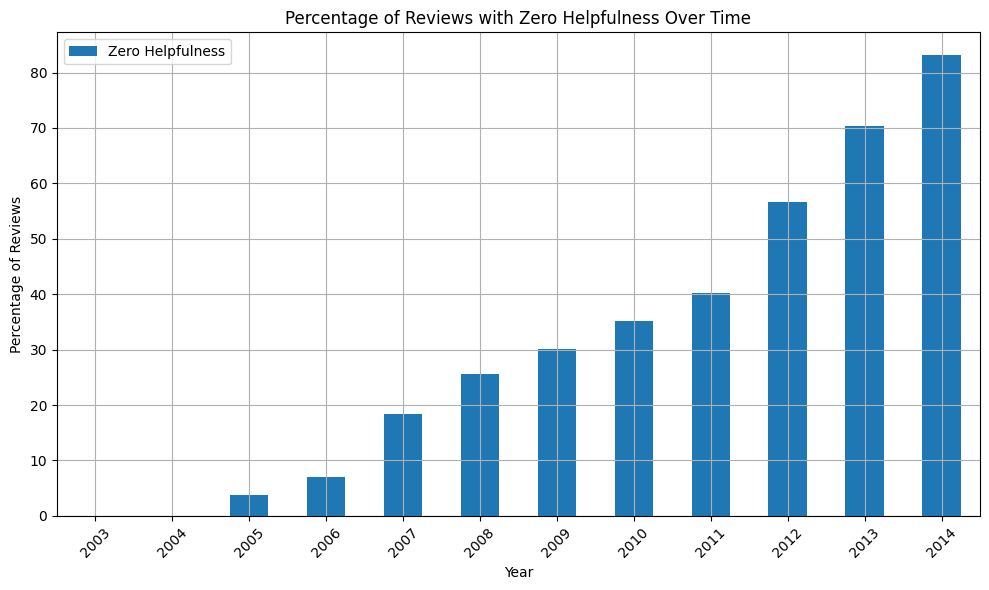

In [13]:
# Plot Distribution of Reviews with Zero Helpfulness
zero_helpfulness = data_unique[data_unique['helpfulness'] == 0].groupby('year').size()
total_reviews = data_unique.groupby('year').size()
zero_helpfulness_percentage = (zero_helpfulness / total_reviews) * 100
plt.figure(figsize=(10, 6))
zero_helpfulness_percentage.plot(kind='bar')
plt.title('Percentage of Reviews with Zero Helpfulness Over Time')
plt.xlabel('Year')
plt.ylabel('Percentage of Reviews')
plt.legend(['Zero Helpfulness'])
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

## Modeling

### Helpfulness Score

In [14]:
df = data_unique
# Create feature that captures helpfulness history of reviewer (previous reviews)
# Sort by reviewTime within each reviewerID group
df = df.sort_values(by=['reviewerID', 'reviewTime'])
# Group by reviewerID
df['cumsumHelpfulness'] = df.groupby('reviewerID')['helpfulness'].cumsum()
df['cumsumHelpfulness'] = df.groupby('reviewerID')['cumsumHelpfulness'].shift(fill_value=0)
df['cumsumReviews'] = df.groupby('reviewerID').cumcount()
# Calculate helpfulness score
df['helpfulnessScore'] = df['cumsumHelpfulness'] / df['cumsumReviews']
df['helpfulnessScore'] = df['helpfulnessScore'].fillna(0)
df = df.sort_values(by='reviewTime')

### Classification Datasets

Train samples: 222820, Counts: [162179  60641] Percentages: [72.784759 27.215241]
Val samples: 27852, Counts: [23895  3957] Percentages: [85.79276174 14.20723826]
Test samples: 27853, Counts: [25500  2353] Percentages: [91.55207698  8.44792302]


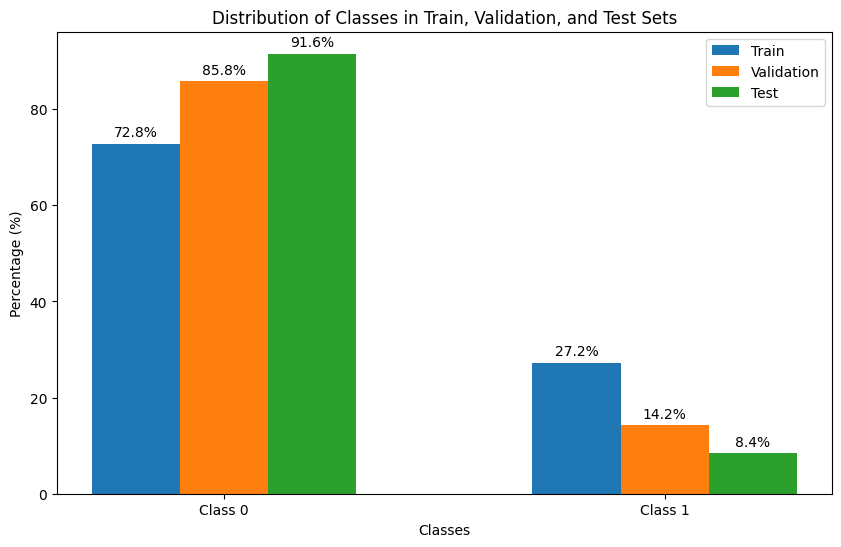

In [15]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['asin', 'helpful', 'helpfulVotes', 'totalVotes', 'unhelpfulVotes',
                     'helpfulness', 'isHelpful', 'cumsumHelpfulness', 'cumsumReviews',
                     'unixReviewTime', 'reviewerID', 'reviewerName', 'summary',
                     'isTopReviewer']).reset_index(drop=True)
y = df['isHelpful'].values
# Create train, val and test sets maintaining the temporal order (80% 10% 10%)
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, train_size=0.8, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, shuffle=False)

# Check the stats of the resulting datasets
train_counts = np.bincount(y_train)
val_counts = np.bincount(y_val)
test_counts = np.bincount(y_test)
train_percentages = train_counts / len(y_train) * 100
val_percentages = val_counts / len(y_val) * 100
test_percentages = test_counts / len(y_test) * 100

print(f"Train samples: {len(y_train)}, Counts: {train_counts}"
      f" Percentages: {train_percentages}")
print(f"Val samples: {len(y_val)}, Counts: {val_counts}"
      f" Percentages: {val_percentages}")
print(f"Test samples: {len(y_test)}, Counts: {test_counts}"
      f" Percentages: {test_percentages}")

# Plotting
labels = ['Class 0', 'Class 1']
x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width, train_percentages, width, label='Train')
bars2 = ax.bar(x, val_percentages, width, label='Validation')
bars3 = ax.bar(x + width, test_percentages, width, label='Test')
ax.set_xlabel('Classes')
ax.set_ylabel('Percentage (%)')
ax.set_title('Distribution of Classes in Train, Validation, and Test Sets')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def add_percentage_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords='offset points',
                    ha='center', va='bottom')

add_percentage_labels(bars1)
add_percentage_labels(bars2)
add_percentage_labels(bars3)

We are dealing with an imbalanced dataset where the majority of labels belong to class 0 (unhelpful).

### Simple Naive Bayes Classifier

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Custom transformer to select a specific column
class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

In [17]:
# Naive Bayes classifier pipeline
pipeline = Pipeline([
    ('selector', TextSelector(key='reviewText')),     # Select 'reviewText' column
    ('vect', CountVectorizer()),                      # Convert text to vector of token counts
    ('clf', MultinomialNB())                          # Naive Bayes classifier
])

# Parameter grid for CountVectorizer
param_grid = {
    'vect__stop_words': [None, 'english'],
    'vect__max_features': [None, 100]
}

# Perform Grid Search Cross-Validation with 3 Stratified Folds
grid_search = GridSearchCV(pipeline, param_grid, scoring='f1',
                           cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate on validation set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
print(classification_report(y_val, y_pred))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters: {'vect__max_features': None, 'vect__stop_words': None}
Best cross-validation score: 0.3226807173096607
              precision    recall  f1-score   support

           0       0.87      0.86      0.87     23895
           1       0.23      0.26      0.24      3957

    accuracy                           0.77     27852
   macro avg       0.55      0.56      0.55     27852
weighted avg       0.78      0.77      0.78     27852



The classifier performs reasonably well at identifying unhelpful reviews. However, only 23% of the reviews predicted as helpful are actually helpful (low precision), and only 26% of the truly helpful reviews are correctly identified (low recall). Additionally, the accuracy is relatively high, but this metric is not very informative for imbalanced datasets where the majority class is negative.

### Latent Semantic Analysis (LSA)

Overview of the process:


1.   TF-IDF transforms the text data into a numerical matrix where each element represents the importance of a word in a review relative to a collection of reviews.
2.   Truncated SVD reduces the dimensionality of the sparse TF-IDF matrix, capturing the most important features.


    

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

def lsa_validate(clf, n_components=100, preprocess_steps=None, param_grid=None, X=X_val, y=y_val):
    # Pipeline with TF-IDF and Truncated SVD (LSA)
    steps = [('selector', TextSelector(key='reviewText')),      # Select 'reviewText' column
             ('tfidf', TfidfVectorizer()),                      # Convert text to TF-IDF
             ('svd', TruncatedSVD(n_components=n_components))]  # Apply SVD (LSA)
    if preprocess_steps:
        steps += preprocess_steps
    steps += [('clf', clf)] # Classifier   
    pipeline = Pipeline(steps)
    if param_grid:
        # Perform Grid Search Cross-Validation with 3 Stratified Folds
        grid_search = GridSearchCV(pipeline, param_grid, scoring='f1',
                                   cv=3, n_jobs=5, verbose=1)
        grid_search.fit(X_train, y_train)
        # Best parameters and best score
        print("Best parameters:", grid_search.best_params_)
        print("Best cross-validation score:", grid_search.best_score_)
        model = grid_search.best_estimator_
    else:
        model = pipeline
        # Train the model
        model.fit(X_train, y_train)
    # Evaluate
    y_pred = model.predict(X)
    print(classification_report(y, y_pred))

#### Finetuning SVD

In [19]:
from sklearn.linear_model import LogisticRegression

param_grid = {
    'svd__n_components': [100, 500, 1000]      # number of components for SVD
}
lsa_validate(LogisticRegression(class_weight='balanced'), param_grid=param_grid)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best parameters: {'svd__n_components': 1000}
Best cross-validation score: 0.43811440999472784
              precision    recall  f1-score   support

           0       0.90      0.62      0.73     23895
           1       0.20      0.58      0.30      3957

    accuracy                           0.62     27852
   macro avg       0.55      0.60      0.52     27852
weighted avg       0.80      0.62      0.67     27852



LSA with Logistic Regression outperforms the Naive Bayes approach in terms of the F1 score (for the positive class).

#### Finetuning Logistic Regression

In [20]:
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10, 100]            # inverse of regularization strength
}
lsa_validate(LogisticRegression(class_weight='balanced'), n_components=1000, param_grid=param_grid)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best parameters: {'clf__C': 0.1}
Best cross-validation score: 0.44033833828046615
              precision    recall  f1-score   support

           0       0.90      0.62      0.73     23895
           1       0.20      0.58      0.30      3957

    accuracy                           0.62     27852
   macro avg       0.55      0.60      0.52     27852
weighted avg       0.80      0.62      0.67     27852



There is no meaningful change in performance.

#### Finetuning K Nearest Neighbors

In [21]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'clf__n_neighbors': [3, 5],               # number of neighbors
    'clf__weights': ['uniform', 'distance'],  # weight function used in prediction
    'clf__metric': ['minkowski', 'cosine']    # metric for distance computation
}
lsa_validate(KNeighborsClassifier(), n_components=1000, param_grid=param_grid)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters: {'clf__metric': 'cosine', 'clf__n_neighbors': 3, 'clf__weights': 'uniform'}
Best cross-validation score: 0.3381790811905178
              precision    recall  f1-score   support

           0       0.87      0.77      0.82     23895
           1       0.19      0.33      0.24      3957

    accuracy                           0.70     27852
   macro avg       0.53      0.55      0.53     27852
weighted avg       0.78      0.70      0.74     27852



The k-nearest neighbors classifier performs worse than logistic regression in terms of the F1 score (for the positive class). However, its accuracy is 8% higher because it is better at identifying unhelpful reviews, which is the majority class.

#### Finetuning Random Forest Classifier

In [21]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'clf__n_estimators': [100, 300],       # number of trees
    'clf__max_depth': [None, 10],          # depth of trees
    'clf__min_samples_split': [2, 5]       # minimum num of samples required to split a node
}
lsa_validate(RandomForestClassifier(n_jobs=5, random_state=117, class_weight='balanced'), n_components=1000, param_grid=param_grid)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


/Users/afonsoeduardo/miniconda3/envs/zen/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'clf__max_depth': 10, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}
Best cross-validation score: 0.4083510380675945
              precision    recall  f1-score   support

           0       0.89      0.71      0.79     23895
           1       0.21      0.47      0.29      3957

    accuracy                           0.67     27852
   macro avg       0.55      0.59      0.54     27852
weighted avg       0.79      0.67      0.72     27852



The random forest classifier performs marginally worse than logistic regression in terms of the F1 score (for the positive class).

#### Neural Network Classifier

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import f1_score


class NNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim=1000, epochs=20, batch_size=32, learning_rate=0.001,
                 weight_decay=0.004):
        self.input_dim = input_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.model_ = None

    def _build_model(self):
        model = Sequential()
        model.add(Input(shape=(self.input_dim,)))
        model.add(Dense(200, activation='relu'))
        model.add(Dense(50, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        optimizer = tf.keras.optimizers.AdamW(learning_rate=self.learning_rate, weight_decay=self.weight_decay)
        model.compile(optimizer=optimizer, loss='binary_crossentropy')
        return model

    def fit(self, X, y):
        self.input_dim = X.shape[1]
        self.model_ = self._build_model()
        self.model_.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=1)
        return self

    def predict(self, X):
        return (self.model_.predict(X) > 0.5).astype("int32")

    def predict_proba(self, X):
        return self.model_.predict(X)

    def score(self, X, y):
        y_pred = self.predict(X)
        return f1_score(y, y_pred)

In [23]:
from sklearn.preprocessing import StandardScaler

lsa_validate(NNClassifier(), n_components=1000, preprocess_steps=[('scaler', StandardScaler())])

Epoch 1/20
6964/6964 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.5772
Epoch 2/20
6964/6964 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.5491
Epoch 3/20
6964/6964 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.5371
Epoch 4/20
6964/6964 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.5120
Epoch 5/20
6964/6964 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.4744
Epoch 6/20
6964/6964 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.4237
Epoch 7/20
6964/6964 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.3840
Epoch 8/20
6964/6964 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.3410
Epoch 9/20
6964/6964 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.3098
Epoch 10/20
6964/6964 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.2821
Epoch 11/20
6964/6964 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.2591
Epoch 12/20
6964/6964 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.2375
Epoch 13/20
6964/6964 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.2195
Epoch 14/20
6964/6964 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.2053
Epoch 15/20
6964/6964 ━━━━━━━

The neural network classifier performs worse than logistic regression in terms of the F1 score (for the positive class).

TODO: Finetune the network and use early stopping.

#### Adding Features

In [22]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

def lsa_add_feature(clf, n_components=1000, overall=False, helpfulnessScore=False, X=X_val, y=y_val):
    # Define preprocessor steps
    steps = [('lsa', Pipeline([('tfidf', TfidfVectorizer()),
                               ('svd', TruncatedSVD(n_components=n_components))
                              ]), 'reviewText')]
    if overall: # Add overall as feature
        steps += [('overall', OneHotEncoder(), ['overall'])]
    if helpfulnessScore: # Add helpfulnessScore as feature
        steps += [('helpfulness', StandardScaler(), ['helpfulnessScore'])]
    preprocessor = ColumnTransformer(transformers=steps)
    # Define the final pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('clf', clf)
    ])
    # Train the model
    pipeline.fit(X_train, y_train)
    # Evaluate
    y_pred = pipeline.predict(X)
    print(classification_report(y, y_pred))

In [23]:
lsa_add_feature(LogisticRegression(C=0.1, class_weight='balanced'), overall=True)

              precision    recall  f1-score   support

           0       0.90      0.62      0.74     23895
           1       0.20      0.58      0.30      3957

    accuracy                           0.62     27852
   macro avg       0.55      0.60      0.52     27852
weighted avg       0.80      0.62      0.67     27852



Adding the product rating as a feature does not improve classification performance.

In [24]:
lsa_add_feature(LogisticRegression(C=0.1, class_weight='balanced'), helpfulnessScore=True)

              precision    recall  f1-score   support

           0       0.90      0.64      0.75     23895
           1       0.20      0.56      0.30      3957

    accuracy                           0.63     27852
   macro avg       0.55      0.60      0.52     27852
weighted avg       0.80      0.63      0.68     27852



Including the HelpfulnessScore as a feature leads to a 1% increase in accuracy, but lowers recall (for the positive class).

#### Test Set

In [25]:
# Evaluate on test set
lsa_add_feature(LogisticRegression(C=0.1, class_weight='balanced'), X=X_test, y=y_test)

              precision    recall  f1-score   support

           0       0.94      0.65      0.77     25500
           1       0.13      0.58      0.21      2353

    accuracy                           0.64     27853
   macro avg       0.54      0.61      0.49     27853
weighted avg       0.87      0.64      0.72     27853



The model’s performance on the test set is inferior to that on the validation set. Specifically, it demonstrates lower precision, resulting in a correspondingly lower F1 score (for the positive class).

### BERT

In [26]:
from tqdm import tqdm
import torch
from transformers import BertTokenizer, BertModel
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier


class BERTEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, model_name='bert-base-uncased'):
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertModel.from_pretrained(model_name)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_encoded = []
        self.model.eval()
        with torch.no_grad():
            for text in tqdm(X['reviewText']):
                inputs = self.tokenizer(text, return_tensors='pt', truncation=True)
                outputs = self.model(**inputs)
                # Average along the sequence length dimension
                embedding = outputs.last_hidden_state.numpy().mean(1).squeeze() 
                X_encoded.append(embedding)
        return np.array(X_encoded)

def bert_embedding(clf, postprocess_steps=None):
    # Define pipeline steps
    steps = [('bert', BERTEncoder())]
    if postprocess_steps:
        steps += postprocess_steps
    steps += [('clf', clf)]
    pipeline = Pipeline(steps)
    
    # Train the model
    pipeline.fit(X_train, y_train)

    # Evaluate on validation set
    print("Validation set")
    y_pred = pipeline.predict(X_val)
    print(classification_report(y_val, y_pred))

    # Evaluate on test set
    print("Test set")
    y_pred = pipeline.predict(X_test)
    print(classification_report(y_test, y_pred))

/Users/afonsoeduardo/miniconda3/envs/zen/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
bert_embedding(LogisticRegression(C=0.1, class_weight='balanced'), postprocess_steps=[('scaler', StandardScaler())])

100%|█████████████████████████████████| 222820/222820 [1:58:36<00:00, 31.31it/s]


Validation set


100%|█████████████████████████████████████| 27852/27852 [13:20<00:00, 34.81it/s]


              precision    recall  f1-score   support

           0       0.90      0.64      0.75     23895
           1       0.21      0.57      0.30      3957

    accuracy                           0.63     27852
   macro avg       0.55      0.60      0.52     27852
weighted avg       0.80      0.63      0.68     27852

Test set


100%|█████████████████████████████████████| 27853/27853 [13:05<00:00, 35.47it/s]


              precision    recall  f1-score   support

           0       0.94      0.66      0.78     25500
           1       0.13      0.57      0.22      2353

    accuracy                           0.65     27853
   macro avg       0.54      0.61      0.50     27853
weighted avg       0.87      0.65      0.73     27853



On the validation set, the F1 score using BERT is similar to that using LSA. However, on the test set, the F1 score is slightly higher.

**Future work:**
* More comprehensive grid search cross-validation
* Finetuning the neural network classifier
* Other classifiers (e.g., gradient boosting, SVM)
* Oversampling of the minority class / Undersampling of the majority class
* Dimensionality reduction methods (e.g., PCA)
* More meaningful embeddings using other bert-like transformers (package sentence_transformers)
* End-to-end training of bert-like transformers with classification head (learning discriminative embeddings)
* Redefine as a 3-class classification problem (unhelpful, neutral, helpful)